## Evaluation of topic modeling results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ChiLit_Topic_Modeling

In [2]:
import octis
from octis.models.LDA import LDA
from octis.models.ProdLDA import ProdLDA
from octis.models.ETM import ETM
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.dataset.dataset import Dataset
import optuna
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
from typing import Tuple, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.io import show
import json
import os
import pickle

In [21]:
chunk_size = 200

In [22]:
octis_folder = f"./octis_{chunk_size}/"
optuna_folder = f"./optuna_{chunk_size}/"

In [23]:
dataset = Dataset()
dataset.load_custom_dataset_from_folder(octis_folder)

In [24]:
def evaluate_metrics(dataset, output, topk=10, measure='c_npmi'):

    diverisity_metric = TopicDiversity(topk=topk) # Initialize metric
    diversity_score = diverisity_metric.score(output) # Compute score of the metric

    coherence_metrics = Coherence(texts=dataset.get_corpus(), #list of our documents
                        measure=measure)
    coherence_score = coherence_metrics.score(output) # Compute score of the metric

    return {'coherence_score' : coherence_score, 'diversity_score' : diversity_score}
    

### OCTIS optimization

In [25]:
def display_octis_optimization(model_name, file_name):
    results = json.load(open(file_name))
    plt.xlabel('Iteration')
    plt.ylabel('Coherence-Diversity Combination')
    plt.title(f'{model_name} Median Coherence-Diversity score per iteration')
    plt.plot(results["f_val"])
    plt.show()

In [26]:
files = {
    "LDA": "OCTIS_LDA.json",
    "ProdLDA": "OCTIS_ProdLDA.json",
    "ETM": "OCTIS_ETM.json"
}

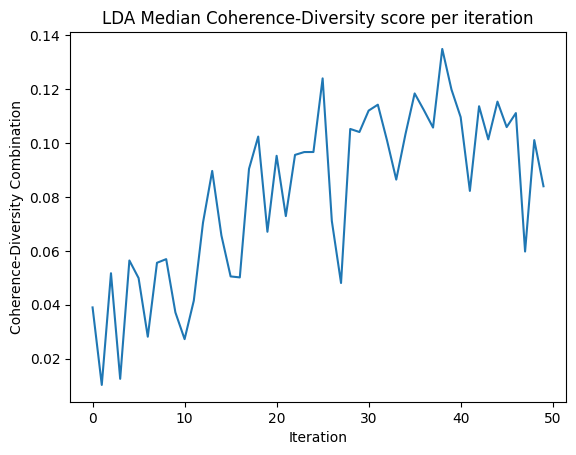

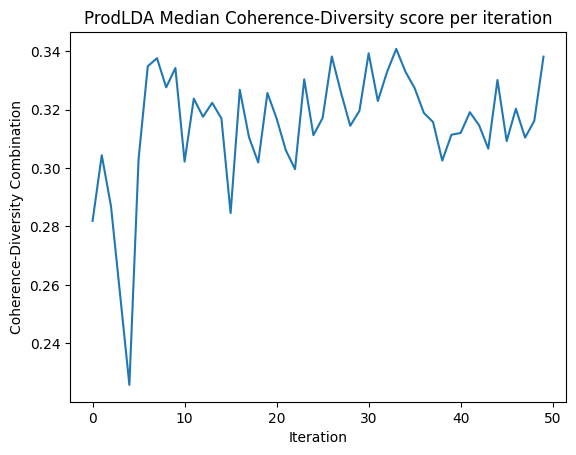

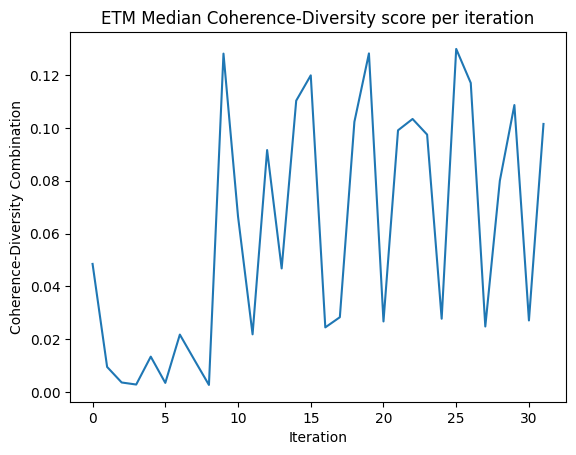

In [27]:
for model_name, file_name in files.items():
    display_octis_optimization(model_name, f"{octis_folder}{file_name}")

### Best results

In [28]:
# Define base colors per model family
palette = {
    "LDA": sns.color_palette("Blues", 2),
    "ProdLDA": sns.color_palette("Greens", 2),
    "ETM": sns.color_palette("Reds", 2),
    "BERTopic" : sns.color_palette("Wistia", 2)
}

# Function to assign colors
def get_color(exp_name):
    if "LDA" in exp_name and "Prod" not in exp_name:
        return palette["LDA"][0] if "OCTIS" in exp_name else palette["LDA"][1]
    elif "ProdLDA" in exp_name:
        return palette["ProdLDA"][0] if "OCTIS" in exp_name else palette["ProdLDA"][1]
    elif "ETM" in exp_name:
        return palette["ETM"][0] if "OCTIS" in exp_name else palette["ETM"][1]
    elif "BERTopic" in exp_name:
        return palette["BERTopic"][0] if "OCTIS" in exp_name else palette["BERTopic"][1]

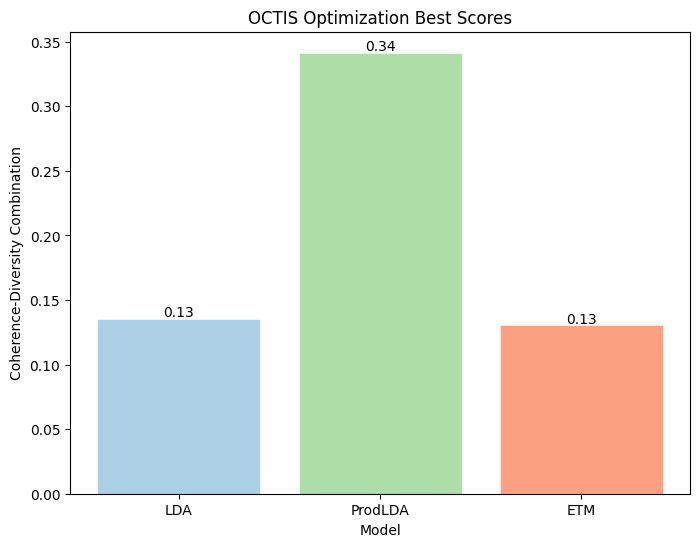

In [29]:
experiment_names = []
performances = []

for name, filename in files.items():
    results = json.load(open(f"{octis_folder}{filename}",'r'))
    value = max(results['f_val'])
    experiment_names.append(name)
    performances.append(value)

# Plot barchart
plt.figure(figsize=(8, 6))
bars = plt.bar(experiment_names, performances)

# Assign different colors automatically
colors = [get_color('OCTIS LDA'), get_color('OCTIS ProdLDA'), get_color('OCTIS ETM')]
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add labels
plt.title("OCTIS Optimization Best Scores")
plt.xlabel("Model")
plt.ylabel("Coherence-Diversity Combination")

# Show values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f"{height:.2f}", 
        ha="center", 
        va="bottom"
    )

plt.show()

### OCTIS/OPTUNA comparison

In [30]:
output_files = {
    "OCTIS LDA": octis_folder + "OCTIS_LDA_output.pkl",
    "OPTUNA LDA": optuna_folder + "OPTUNA_LDA_output.pkl",
    "OCTIS ProdLDA": octis_folder + "OCTIS_ProdLDA_output.pkl",
    "OPTUNA ProdLDA": optuna_folder + "OPTUNA_ProdLDA_output.pkl",
    "OCTIS ETM": octis_folder + "OCTIS_ETM_output.pkl",       
    "OPTUNA ETM": optuna_folder + "OPTUNA_ETM_output.pkl",
}

In [31]:
final_results = {}
for name, filename in output_files.items():
    print(filename)
    result = pickle.load(open(filename, "rb"))
    metrics =  evaluate_metrics(dataset, result) 
    metrics['num_topics'] = len(result['topics'])
    final_results[name] = metrics

./octis_200/OCTIS_LDA_output.pkl
./optuna_200/OPTUNA_LDA_output.pkl
./octis_200/OCTIS_ProdLDA_output.pkl
./optuna_200/OPTUNA_ProdLDA_output.pkl
./octis_200/OCTIS_ETM_output.pkl
./optuna_200/OPTUNA_ETM_output.pkl


In [32]:
# OPTUNA BERTopic best trial results (see notebook)
metrics = {
    'coherence_score': 0.0901,
    'diversity_score': 0.8667,
    'num_topics': 11
}
final_results['OPTUNA BERTopic'] = metrics


In [33]:
final_results

{'OCTIS LDA': {'coherence_score': -0.025742046224017996,
  'diversity_score': 0.73,
  'num_topics': 10},
 'OPTUNA LDA': {'coherence_score': -0.022006837349015353,
  'diversity_score': 0.8214285714285714,
  'num_topics': 14},
 'OCTIS ProdLDA': {'coherence_score': 0.04885466501425346,
  'diversity_score': 1.0,
  'num_topics': 16},
 'OPTUNA ProdLDA': {'coherence_score': 0.05093560504315979,
  'diversity_score': 0.9777777777777777,
  'num_topics': 18},
 'OCTIS ETM': {'coherence_score': -0.007566271584983471,
  'diversity_score': 0.11,
  'num_topics': 10},
 'OPTUNA ETM': {'coherence_score': 0.0036007976112016117,
  'diversity_score': 0.42727272727272725,
  'num_topics': 11},
 'OPTUNA BERTopic': {'coherence_score': 0.0901,
  'diversity_score': 0.8667,
  'num_topics': 11}}

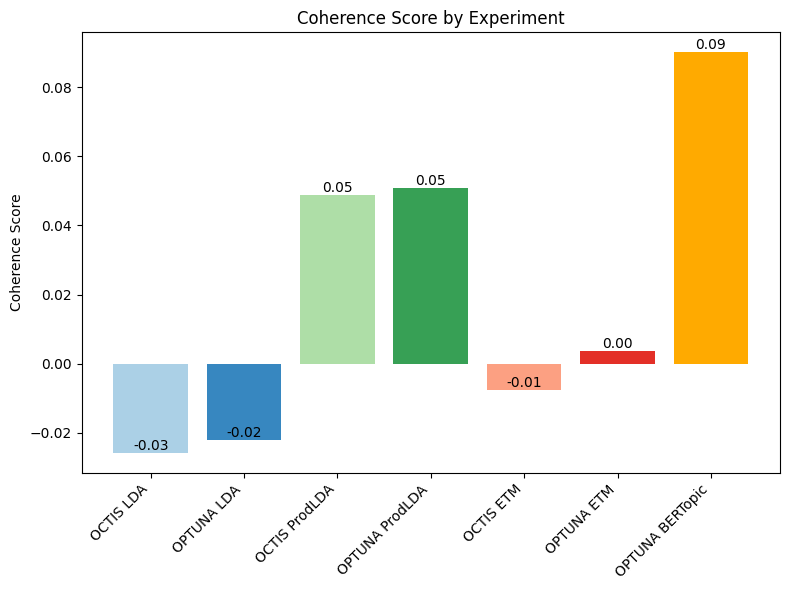

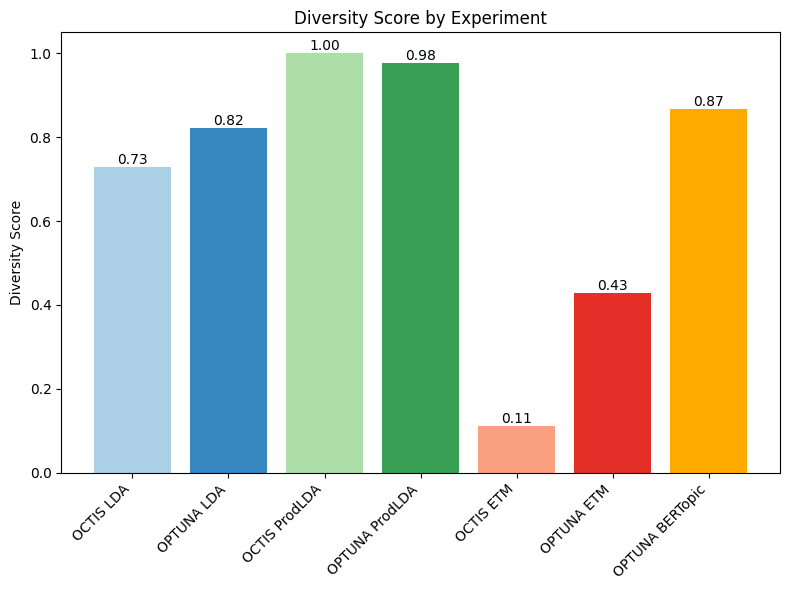

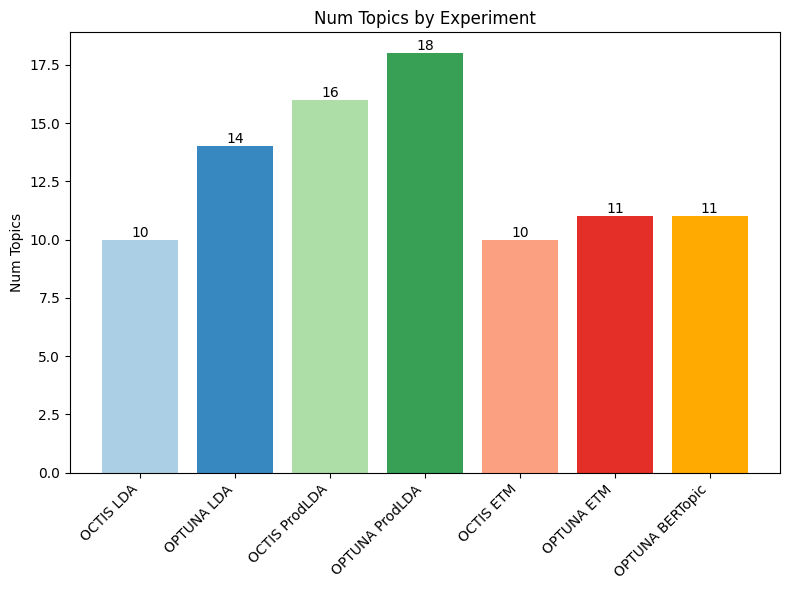

In [34]:
# Convert dict to DataFrame
df = pd.DataFrame(final_results).T

colors = [get_color(name) for name in df.index]

# Bar charts for each metric
metrics = ["coherence_score", "diversity_score", "num_topics"]

for metric in metrics:
    plt.figure(figsize=(8, 6))
    bars = plt.bar(df.index, df[metric], color=colors)
    
    plt.title(f"{metric.replace('_', ' ').title()} by Experiment")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45, ha="right")
    
    # Annotate values
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 height,
                 f"{height:.2f}" if metric != "num_topics" else f"{int(height)}",
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


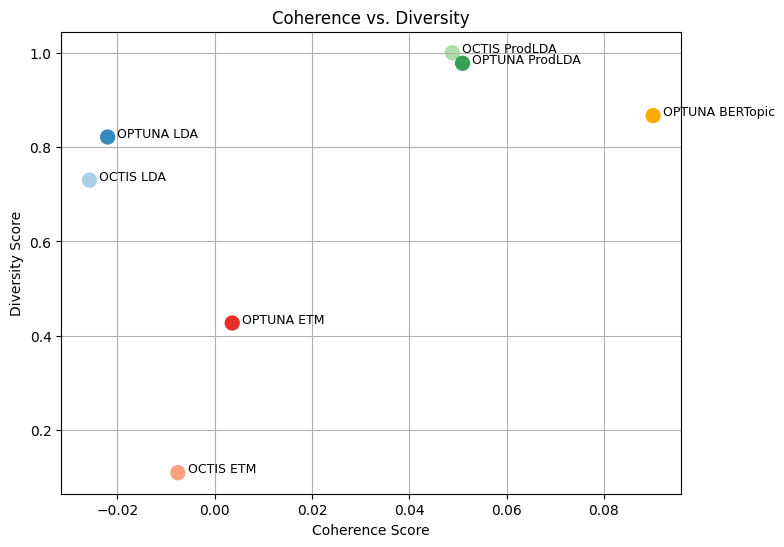

In [106]:
# Scatter plot: coherence vs diversity
plt.figure(figsize=(8, 6))
plt.scatter(df["coherence_score"], df["diversity_score"], c=colors, s=100)

# Label each point with experiment name
for i, name in enumerate(df.index):
    plt.text(df["coherence_score"][i] + 0.002, df["diversity_score"][i], name, fontsize=9)

plt.xlabel("Coherence Score")
plt.ylabel("Diversity Score")
plt.title("Coherence vs. Diversity")
plt.grid(True)
plt.show()

### Visualizing OPTUNA optimization

In [36]:
def visualize_results(name, study):
    """Visualize the Pareto front"""
    # Extract all trial results
    trials = study.trials
    objectives = np.array([trial.values for trial in trials if trial.values is not None])

    if len(objectives) == 0:
        print("No completed trials to visualize")
        return

    # Extract Pareto front
    pareto_trials = study.best_trials
    pareto_objectives = np.array([trial.values for trial in pareto_trials])

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot all trials
    plt.scatter(objectives[:, 0], objectives[:, 1],
               alpha=0.6, c='lightblue', label='All trials')

    # Plot Pareto front
    plt.scatter(pareto_objectives[:, 0], pareto_objectives[:, 1],
               c='red', label='Pareto front', zorder=5)

    # Connect Pareto front points
    sorted_pareto = pareto_objectives[np.argsort(pareto_objectives[:, 0])]
    plt.plot(sorted_pareto[:, 0], sorted_pareto[:, 1],
             'r--', alpha=0.7, linewidth=2)

    plt.xlabel('Coherence (f1)')
    plt.ylabel('Diversity (f2)')
    plt.title(f'{name} Pareto Front')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


### Load studies

In [37]:
LDA_study = optuna.load_study(
    storage=f"sqlite:///{optuna_folder}LDA_Study.db",
    study_name="LDA_Study"
)

ProdLDA_study =  optuna.load_study(
    storage=f"sqlite:///{optuna_folder}ProdLDA_Study.db",
    study_name="ProdLDA_Study"
)

ETM_study =  optuna.load_study(
    storage=f"sqlite:///{optuna_folder}ETM_Study.db",
    study_name="ETM_Study"
)

BERTopic_study =  optuna.load_study(
    storage=f"sqlite:///{optuna_folder}BERTopic_Study.db",
    study_name="BERTopic_Study"
)


In [97]:
import warnings
warnings.filterwarnings("ignore")
metrics = ['Coherence', 'Diversity']
LDA_study.set_metric_names(metrics)
ProdLDA_study.set_metric_names(metrics)
ETM_study.set_metric_names(metrics)
BERTopic_study.set_metric_names(metrics)

In [107]:
#optuna.visualization.plot_optimization_history(BERTopic_study, target = lambda t: t.values[1], target_name = "Diversity")

### Pareto Front

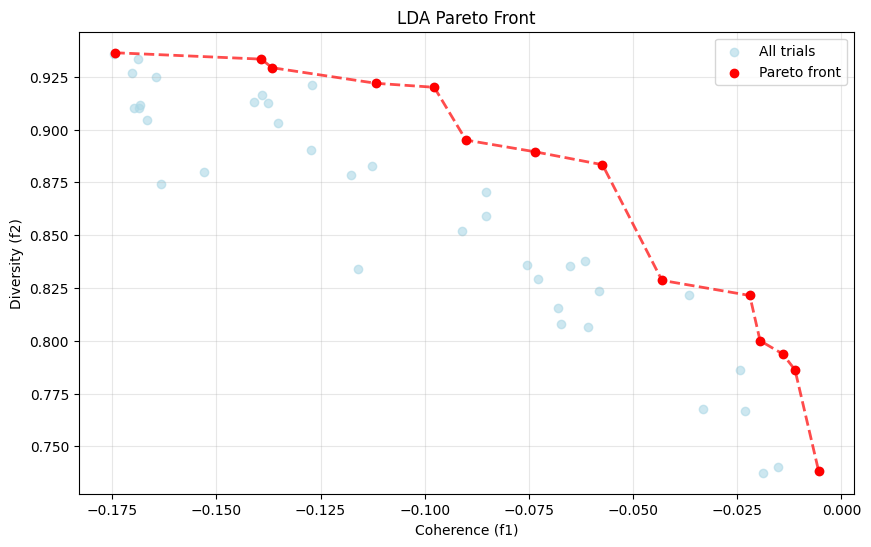

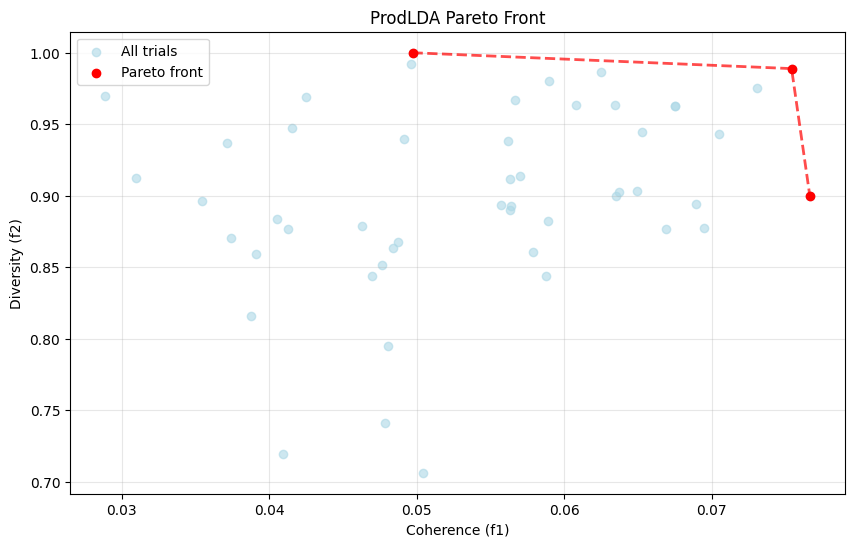

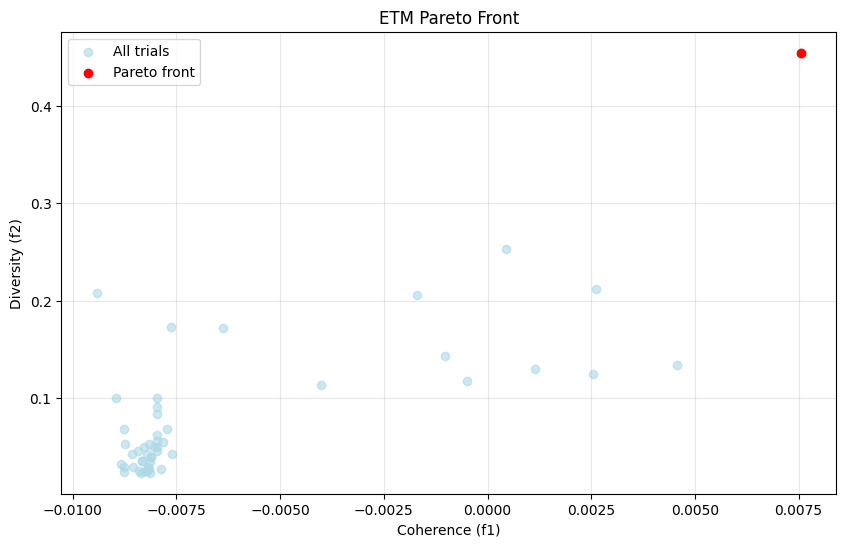

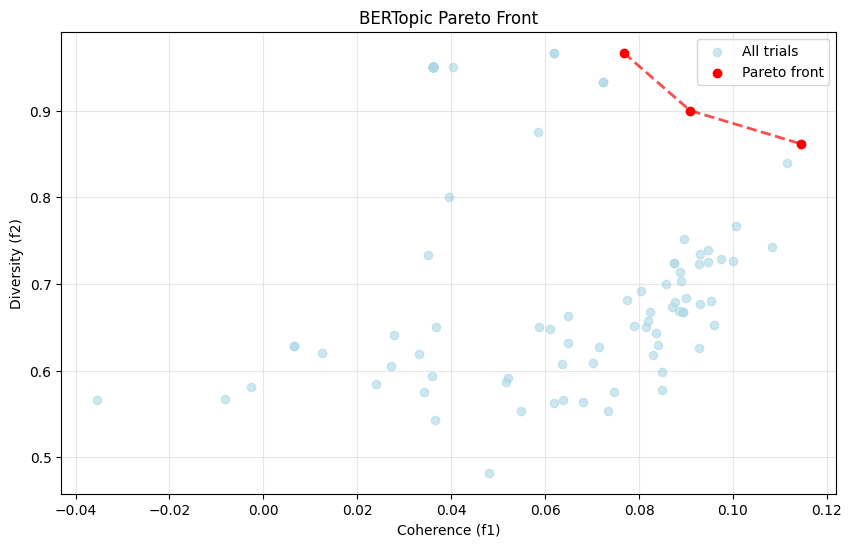

In [98]:
visualize_results('LDA', LDA_study)
visualize_results('ProdLDA', ProdLDA_study)
visualize_results('ETM', ETM_study)
visualize_results('BERTopic', BERTopic_study)

### Hyperparameter Importances

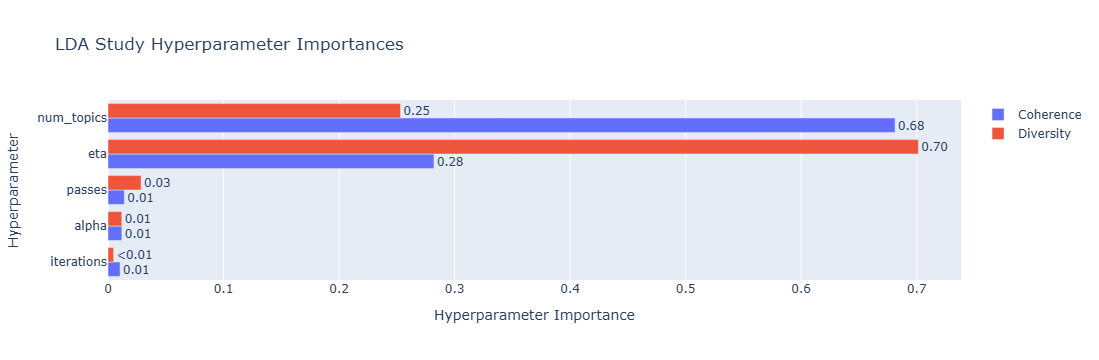

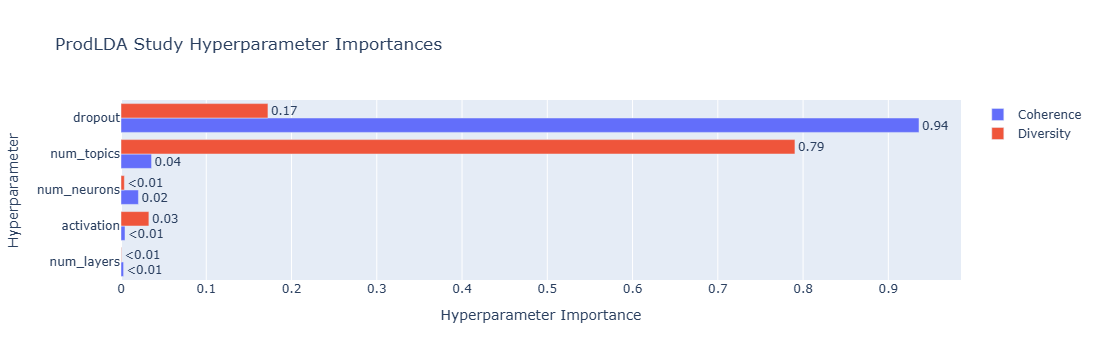

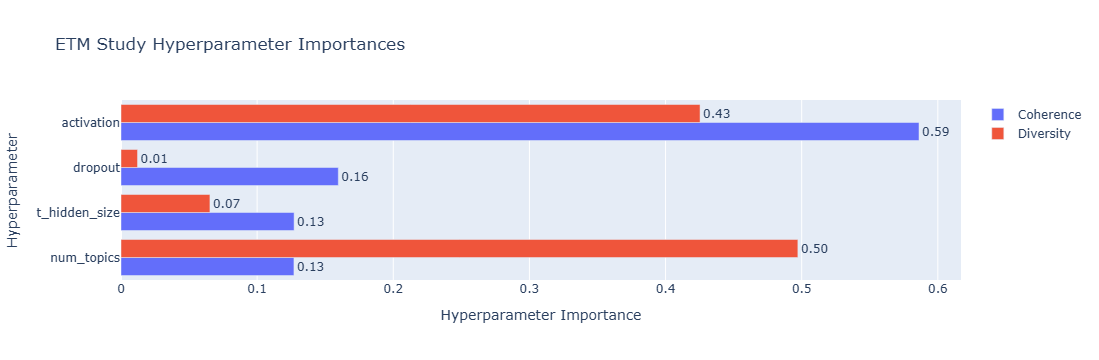

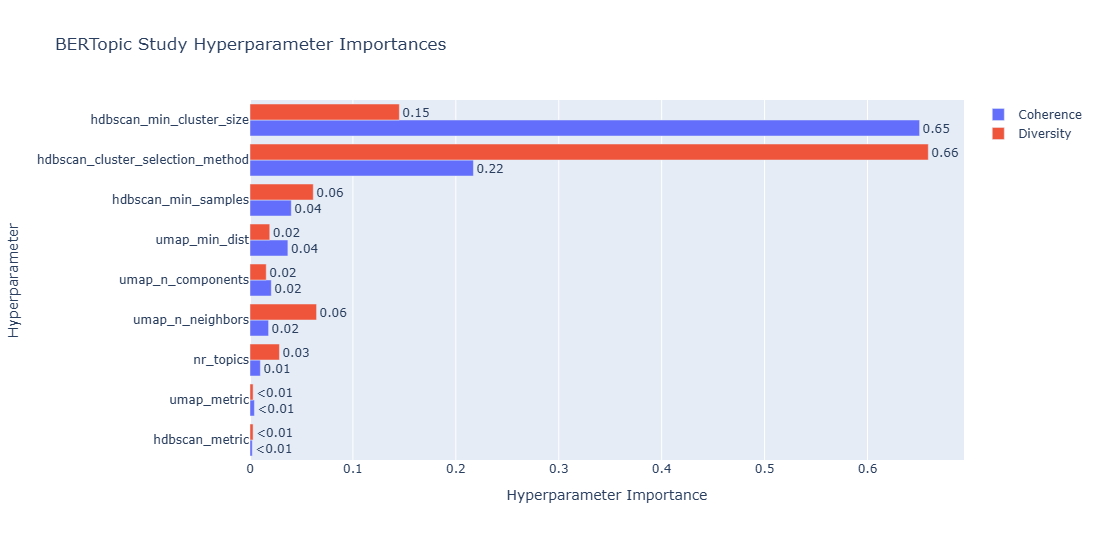

In [125]:
fig = optuna.visualization.plot_param_importances(LDA_study)
fig.update_layout(title="LDA Study Hyperparameter Importances")
show(fig)

fig = optuna.visualization.plot_param_importances(ProdLDA_study)
fig.update_layout(title="ProdLDA Study Hyperparameter Importances")
show(fig)

fig = optuna.visualization.plot_param_importances(ETM_study)
fig.update_layout(title="ETM Study Hyperparameter Importances")
show(fig)

fig = optuna.visualization.plot_param_importances(BERTopic_study)
fig.update_layout(title="BERTopic Study Hyperparameter Importances", autosize=True, height=540)
show(fig)


### Comparison of ProdLDA and BERTopic topics

In [111]:
ProdLDA_output = pickle.load(open(optuna_folder + "OPTUNA_ProdLDA_output.pkl", "rb"))

In [112]:
ProdLDA_output['topics']

[['force',
  'enemy',
  'attack',
  'troops',
  'order',
  'french',
  'march',
  'advance',
  'army',
  'number'],
 ['face',
  'arm',
  'voice',
  'heart',
  'tear',
  'eye',
  'hand',
  'lay',
  'speak',
  'bed'],
 ['dragon',
  'red',
  'buy',
  'engine',
  'let',
  'gold',
  'birthday',
  'tea',
  'handkerchief',
  'bun'],
 ['sir',
  'money',
  'pay',
  'matter',
  'name',
  'explain',
  'rod',
  'bottle',
  'paper',
  'shilling'],
 ['boy',
  'study',
  'fellow',
  'fifth',
  'form',
  'school',
  'sixth',
  'class',
  'half',
  'match'],
 ['captain',
  'man',
  'blood',
  'deck',
  'shout',
  'strike',
  'hand',
  'spear',
  'dead',
  'roll'],
 ['pleasure',
  'own',
  'home',
  'delight',
  'visit',
  'affection',
  'happiness',
  'church',
  'spend',
  'pupil'],
 ['snow',
  'mulgar',
  'nod',
  'traveller',
  'jacket',
  'hut',
  'shadow',
  'creep',
  'sing',
  'smell'],
 ['ready',
  'dog',
  'work',
  'animal',
  'boat',
  'cut',
  'tree',
  'wood',
  'tent',
  'carry'],
 ['gard

In [113]:
ProdLDA_topic_words = []
for topic in ProdLDA_output['topics']:
    ProdLDA_topic_words.append(' '.join([word for word in topic]))
print(ProdLDA_topic_words)

['force enemy attack troops order french march advance army number', 'face arm voice heart tear eye hand lay speak bed', 'dragon red buy engine let gold birthday tea handkerchief bun', 'sir money pay matter name explain rod bottle paper shilling', 'boy study fellow fifth form school sixth class half match', 'captain man blood deck shout strike hand spear dead roll', 'pleasure own home delight visit affection happiness church spend pupil', 'snow mulgar nod traveller jacket hut shadow creep sing smell', 'ready dog work animal boat cut tree wood tent carry', 'garden cuckoo door feel fairy begin dream answer seem window', 'rock sea rise water island wave boat mountain high shore', 'live world grow year learn sea call land thing great', 'boobie indent goggle cholera walnut fearfulness hitherto bonnie circus diddle', 'horse road side house window run stable leg master stand', 'day mother child old remember mamma dear kind happy time', 'guy glad papa hope right bad wrong much sure sorry', 're

In [42]:
BERTopic_topic_words = [
    'father own dear much room poor hope love wish letter',
    'weasel fly mulgar long tail big bird night stand squirrel',
    'ship sea boat captain island sail deck shore wind vessel',
    'school fellow study paper room fifth mind mean own form',
    'mother child father ask want baby girl room lady like',
    'attack force enemy fire troops fort gun army french advance',
    'king queen prince royal person family lady palace knight princess',
    'night light dream cry fall face voice sleep lie heart',
    'horse master driver cab engine rein train drive carriage stable',
    'reply cottage indian forest animal dog lodge rifle intendant venison',
    'rock chalk volcano earthquake lava ice sea stone sand mountain'
]

In [119]:
# Load topic labels (generated by ChatGPT)
with open(optuna_folder + "/ProdLDA_Topic_Labels.json", 'r') as file:
  ProdLDA_labels = json.load(file)

with open("./bertopic/BERTopic_Topic_Labels.json", 'r') as file:
  BERTopic_labels = json.load(file)



In [124]:
xticklabels = [value.lower() for key, value in BERTopic_labels.items()]
yticklabels = [value['primary_label'].lower() for key, value in ProdLDA_labels.items()]

In [116]:
# Load sentence transformer (light model for speed, choose larger if needed)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode topics
ProdLDA_embeddings = model.encode(ProdLDA_topic_words, convert_to_tensor=True)
BERTopic_embeddings = model.encode(BERTopic_topic_words, convert_to_tensor=True)

In [117]:
# Create similary matrix
sim_matrix = cosine_similarity(ProdLDA_embeddings, BERTopic_embeddings)

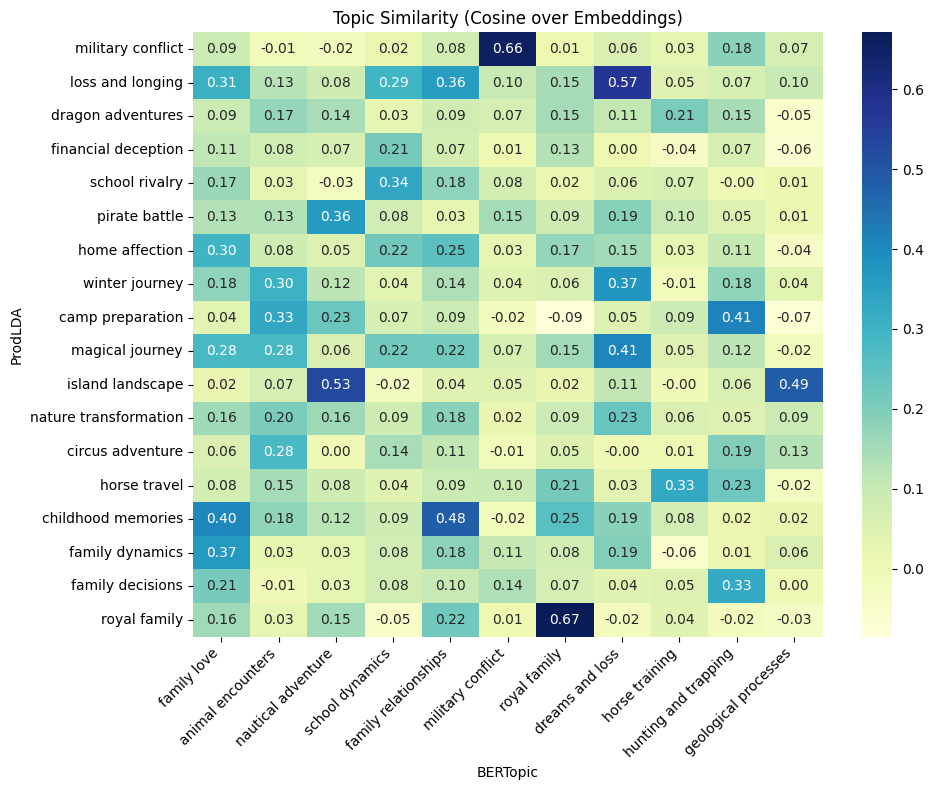

In [118]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(sim_matrix, annot=True, cmap="YlGnBu", fmt=".2f",
            xticklabels=xticklabels, #[f"BERTopic {j}" for j in range(len(BERTopic_topic_words))],
            yticklabels=yticklabels) #[f"ProdLDA {i}" for i in range(len(ProdLDA_topic_words))])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Topic Similarity (Cosine over Embeddings)")
plt.xlabel("BERTopic")
plt.ylabel("ProdLDA")
plt.tight_layout()
plt.show()

In [49]:
n_prodlda, n_bertopic = sim_matrix.shape

In [50]:
max_dim = max(n_prodlda, n_bertopic)

# Initialize with zeros
padded_sim = np.zeros((max_dim, max_dim))
padded_sim[:n_prodlda, :n_bertopic] = sim_matrix

In [51]:
# Convert similarity to cost
cost_matrix = -padded_sim  

# Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(cost_matrix)

In [52]:
matches = []
for i, j in zip(row_ind, col_ind):
    if i < n_prodlda and j < n_bertopic:  # valid match
        matches.append((i, j, sim_matrix[i, j]))

In [53]:
for i, j, score in matches:
    print(f"ProdLDA {i}  <-->  BERTopic {j}   (similarity = {score:.2f})")

ProdLDA 0  <-->  BERTopic 5   (similarity = 0.66)
ProdLDA 1  <-->  BERTopic 7   (similarity = 0.57)
ProdLDA 4  <-->  BERTopic 3   (similarity = 0.34)
ProdLDA 5  <-->  BERTopic 2   (similarity = 0.36)
ProdLDA 7  <-->  BERTopic 1   (similarity = 0.30)
ProdLDA 8  <-->  BERTopic 9   (similarity = 0.41)
ProdLDA 10  <-->  BERTopic 10   (similarity = 0.49)
ProdLDA 13  <-->  BERTopic 8   (similarity = 0.33)
ProdLDA 14  <-->  BERTopic 4   (similarity = 0.48)
ProdLDA 15  <-->  BERTopic 0   (similarity = 0.37)
ProdLDA 17  <-->  BERTopic 6   (similarity = 0.67)


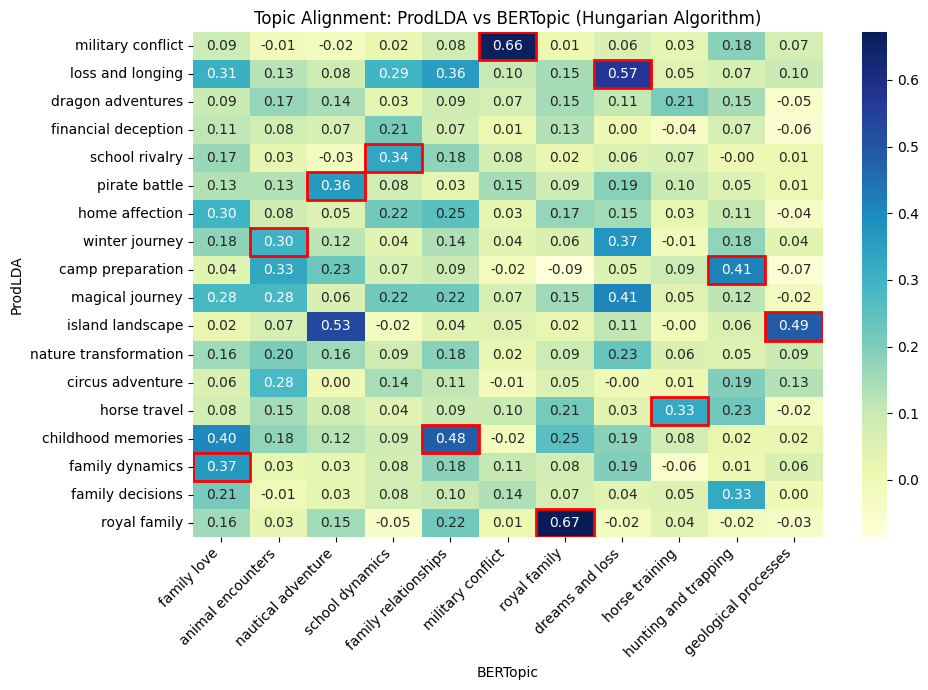

In [104]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(sim_matrix, annot=True, cmap="YlGnBu", fmt=".2f",
            xticklabels=xticklabels,
            yticklabels=yticklabels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
# Highlight matches
for i, j, _ in matches:
    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.title("Topic Alignment: ProdLDA vs BERTopic (Hungarian Algorithm)")
plt.xlabel("BERTopic")
plt.ylabel("ProdLDA")
plt.tight_layout()
plt.show()